<a href="https://colab.research.google.com/github/andrewcfreeman/SimpleHashCodes/blob/main/hash_codes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [38]:
import random
import string
from typing import Type, TypeVar
import sys
import numpy as np
from sortedcontainers import SortedList  # For the "storing elsewhere" approach to collision resolution


def str_to_class(classname):
    """
    https://stackoverflow.com/questions/1176136/convert-string-to-python-class-object

    Trying to force Python into a semi-functional style
    """
    return getattr(sys.modules[__name__], classname)


class Coder:
    """https://stackoverflow.com/questions/55751368/python-how-to-pass-to-a-function-argument-type-of-a-class-object
    -typing """

    T = 0
    table = []
    collision_res_type = ''
    buckets = []

    def __init__(self):
        print("Creating a %s" % self.__class__.__name__)

    def init_buckets(self):
        if self.collision_res_type == 'store':
            self.buckets = np.empty(self.T, dtype=SortedList)

    def insert(self, h, s, x):
        if self.table[h] is None:
            self.table[h] = s
        else:
            self.resolve_collision(h, s, x)

    def resolve_collision(self, h, s, x):
        if self.collision_res_type == 'append':
            self.resolve_append(h, s)
        elif self.collision_res_type == 'store':
            self.resolve_store(h, s, x)
        else:
            print("Bad value for collision resolution type")

    def resolve_append(self, h, s):
        for i in range(self.T):
            if self.table[(i + h) % self.T] is None:
                self.table[(i + h) % self.T] = s
                print("Hash for index ", s, " appended to location ", (i + h) % self.T )
                return
        print("Could not resolve collision for hash ", h)

    def resolve_store(self, h, s, x):
        if self.table[h] >= 0:
            # Then we need to create new bucket
            self.buckets[h] = []
            self.buckets[h].extend([(x[self.table[h]], self.table[h]) , (x[s], s)]) # Init with the two conflicting strings
            self.table[h] = -h
        else:
            self.buckets[h].extend([(x[s], s)])
        self.buckets[h].sort(key=lambda tup: tup[0])

    def lookup(self, h, xs, x):
        if self.table[h] is None:
            return False, []
        else:
            s = self.table[h]
            if s < 0:  # Then the resolution type is 'store' and it's in a bucket
                bucket = self.buckets[-s]
                print("Looking in bucket ", -s, "...")
                for entry in bucket:
                     if entry[0] == xs:
                         return True, entry[1]
                return False, []
            elif x[s] == xs:
                return True, s
            else:
                # Search the hash table for for pointers to xs matching x
                h_iter = h+1
                if (h_iter == len(self.table)):
                        h_iter = 0
                while (h != h_iter):
                
                    if (x[self.table[h_iter]] == xs):
                        return True, self.table[h_iter]
                    h_iter += 1
                    if (h_iter == len(self.table)):
                        h_iter = 0
                return False, []
            # if xs == x

TCoder = TypeVar("TCoder", bound=Coder)


class Div(Coder):

    def __init__(self, collision_res_type):
        self.T = 37  # Prime number, preferably far from power of 2
        self.table = np.full(self.T, None)  # Initialize table with None
        self.collision_res_type = collision_res_type
        self.init_buckets()

    def hash(self, x) -> None:
        # If a string is input, convert it to an int
        if isinstance(x, str):
            charsum = 0
            for character in range(0, len(x)):
                charsum += ord(x[character])
            x = charsum
        return x % self.T


class Var_string(Coder):

    def __init__(self, collision_res_type):
        self.T = 256
        self.table = np.full(self.T, None)  # Initialize table with None
        self.collision_res_type = collision_res_type
        self.init_buckets()

    def hash(self, x) -> None:
        if isinstance(x, str):
            sum = 0
            for i in range(len(x)):
                sum = (sum + ord(x[i])) % 256
            return sum


class Var_string_xor(Coder):
    rand8 = np.random.permutation(range(0, 256))

    def __init__(self, collision_res_type):
        self.T = 65536
        self.table = np.full(self.T, None)  # Initialize table with None
        self.collision_res_type = collision_res_type
        self.init_buckets()

    def hash(self, x) -> None:
        if isinstance(x, str):
            sum1 = ord(x[0])
            sum2 = ord(x[1])
            for i in range(1, len(x)):
                sum1 = self.rand8[sum1 ^ ord(x[i])]
                sum2 = self.rand8[sum2 ^ ord(x[i])]

            return (sum1 << 8) | sum2


def resolve_collision(v: Coder, h, s) -> None:
    v.resolve_collision(h, s)


def instantiate(class_to_instantiate: Type[TCoder], collision_res_type) -> TCoder:
    return class_to_instantiate(collision_res_type)  # create an instance


# Note use of zero-indexing throughout, unlike the textbook

# **Div hashing with 'append' collision handling**

---



In [44]:
x_size = 40
x = np.empty(x_size, dtype=object)
y = np.copy(x)
for i in range(x_size):
    x[i] = tmp = ''.join(random.choices(string.ascii_uppercase, k=4))
    y[i] = tmp = ''.join(random.choices(string.ascii_uppercase, k=10))

coder = instantiate(str_to_class('Div'), 'append')

for s in range(len(x)):
    h = coder.hash(x[s])
    coder.insert(h, s, x)

h = coder.hash(x[1])
found, loc = coder.lookup(h, x[1], x)
if found:
    print("Found record ", x[loc], " with data ", y[loc])
else:
    print("Record not found")

Hash for index  5  appended to location  13
Hash for index  13  appended to location  15
Hash for index  15  appended to location  7
Hash for index  18  appended to location  11
Hash for index  19  appended to location  17
Hash for index  21  appended to location  28
Hash for index  22  appended to location  18
Hash for index  23  appended to location  19
Hash for index  25  appended to location  21
Hash for index  29  appended to location  23
Hash for index  30  appended to location  25
Hash for index  32  appended to location  31
Hash for index  33  appended to location  32
Hash for index  34  appended to location  34
Hash for index  36  appended to location  36
Could not resolve collision for hash  31
Could not resolve collision for hash  32
Could not resolve collision for hash  27
Found record  DVKO  with data  LVKAQBVSPI


# **Div hashing with 'store elsewhere' collision handling**

---



In [42]:
x_size = 200
x = np.empty(x_size, dtype=object)
y = np.copy(x)
for i in range(x_size):
    x[i] = tmp = ''.join(random.choices(string.ascii_uppercase, k=4))
    y[i] = tmp = ''.join(random.choices(string.ascii_uppercase, k=10))

coder = instantiate(str_to_class('Div'), 'store')

for s in range(len(x)):
    h = coder.hash(x[s])
    coder.insert(h, s, x)

h = coder.hash(x[1])
# h = coder.hash("[fji")
found, loc = coder.lookup(h, x[1], x)
if found:
    print("Found record ", x[loc], " with data ", y[loc])
else:
    print("Record not found")

Looking in bucket  36 ...
Found record  QZUL  with data  HWYXEBBWAN


# **var_string hashing with 'append' collision handling**

---



In [9]:
x_size = 260
x = np.empty(x_size, dtype=object)
y = np.copy(x)
for i in range(x_size):
    x[i] = tmp = ''.join(random.choices(string.ascii_uppercase, k=4))
    y[i] = tmp = ''.join(random.choices(string.ascii_uppercase, k=10))

coder = instantiate(str_to_class('Var_string'), 'append')

for s in range(len(x)):
    h = coder.hash(x[s])
    coder.insert(h, s, x)

h = coder.hash(x[1])
found, loc = coder.lookup(h, x[1], x)
if found:
    print("Found record ", x[loc], " with data ", y[loc])
else:
    print("Record not found")

Hash for index  8  appended to location  58
Hash for index  11  appended to location  51
Hash for index  14  appended to location  66
Hash for index  15  appended to location  52
Hash for index  16  appended to location  59
Hash for index  20  appended to location  64
Hash for index  21  appended to location  53
Hash for index  22  appended to location  55
Hash for index  28  appended to location  56
Hash for index  29  appended to location  61
Hash for index  31  appended to location  62
Hash for index  32  appended to location  67
Hash for index  36  appended to location  69
Hash for index  37  appended to location  32
Hash for index  40  appended to location  72
Hash for index  41  appended to location  73
Hash for index  42  appended to location  75
Hash for index  43  appended to location  37
Hash for index  44  appended to location  77
Hash for index  45  appended to location  39
Hash for index  46  appended to location  79
Hash for index  47  appended to location  81
Hash for in

# **var_string hashing with 'store elsewhere' collision handling**

---



In [48]:
x_size = 10000
x = np.empty(x_size, dtype=object)
y = np.copy(x)
for i in range(x_size):
    x[i] = tmp = ''.join(random.choices(string.ascii_uppercase, k=4))
    y[i] = tmp = ''.join(random.choices(string.ascii_uppercase, k=10))

coder = instantiate(str_to_class('Var_string'), 'store')

for s in range(len(x)):
    h = coder.hash(x[s])
    coder.insert(h, s, x)

h = coder.hash(x[1])
# h = coder.hash("[fji")

found, loc = coder.lookup(h, x[1], x)
if found:
    print("Found record ", x[loc], " with data ", y[loc])
else:
    print("Record not found")

Looking in bucket  41 ...
Found record  DCVL  in bucket  41  with data  FZGQLNQXKA


# **var_string_xor hashing with 'append' collision handling**

---



In [10]:
x_size = 65540 # Need 16-bit hashes, so this much data will ensure some collisions
x = np.empty(x_size, dtype=object)
y = np.copy(x)
for i in range(x_size):
    x[i] = tmp = ''.join(random.choices(string.ascii_uppercase, k=4))
    y[i] = tmp = ''.join(random.choices(string.ascii_uppercase, k=10))

coder = instantiate(str_to_class('Var_string_xor'), 'append')

for s in range(len(x)):
    h = coder.hash(x[s])
    coder.insert(h, s, x)

h = coder.hash(x[1])
found, loc = coder.lookup(h, x[1], x)
if found:
    print("Found record ", x[loc], " with data ", y[loc])
else:
    print("Record not found")


Streaming output truncated to the last 5000 lines.
Hash for index  60531  appended to location  47995
Hash for index  60532  appended to location  11961
Hash for index  60533  appended to location  58901
Hash for index  60534  appended to location  11955
Hash for index  60535  appended to location  61286
Hash for index  60536  appended to location  57711
Hash for index  60537  appended to location  25039
Hash for index  60538  appended to location  6989
Hash for index  60539  appended to location  52814
Hash for index  60540  appended to location  6990
Hash for index  60541  appended to location  27887
Hash for index  60542  appended to location  9125
Hash for index  60543  appended to location  11029
Hash for index  60544  appended to location  43175
Hash for index  60545  appended to location  11033
Hash for index  60546  appended to location  51621
Hash for index  60547  appended to location  14877
Hash for index  60548  appended to location  55965
Hash for index  60549  appended to

# **var_string_xor hashing with 'store elsewhere' collision handling**

---




In [49]:
x_size = 100000
x = np.empty(x_size, dtype=object)
y = np.copy(x)
for i in range(x_size):
    x[i] = tmp = ''.join(random.choices(string.ascii_uppercase, k=5))
    y[i] = tmp = ''.join(random.choices(string.ascii_uppercase, k=10))

coder = instantiate(str_to_class('Var_string_xor'), 'store')

for s in range(len(x)):
    h = coder.hash(x[s])
    coder.insert(h, s, x)

h = coder.hash(x[1])
found, loc = coder.lookup(h, x[1], x)
if found:
    print("Found record ", x[loc], " with data ", y[loc])
else:
    print("Record not found")


Looking in bucket  4474 ...
Found record  AWVYO  with data  EVBYEEADLY


# **Just for fun: detect different regions in an edited image with hashing**

---



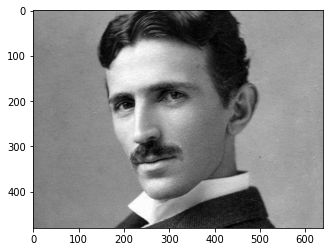

Hash 1:  MAMRVNXRPJTBHSXHYOENAGEWUOPWMDIRYQPCERATSIYLUBVG


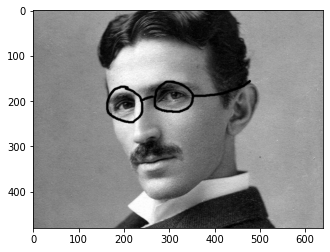

Hash 2:  MAMRVNXRPJTKHGIHYOAPNVEWUOUWMDIRYQPCERATSIYLUBVG


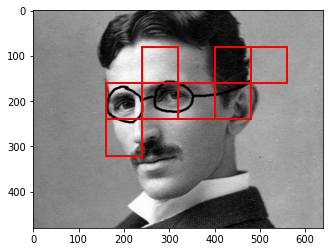

In [ ]:
from PIL import Image
from matplotlib import pyplot as plt
import requests
from io import BytesIO
import numpy as np


block_size = 80     # Unconventional block size but for simplicity with this example
def hash_image(image):
    w = image.shape[1]   # image height
    h = image.shape[0]   # image width
    hash = ''
    for i in range(int(h / block_size)):
        for j in range(int(w / block_size)):
            block = image[i * block_size: (i+1) * block_size, j * block_size: (j+1) * block_size]
            block_hash = chr(int(np.sum(block) % 26 + 65))
            hash = hash + block_hash
    return hash
url = 'https://github.com/andrewcfreeman/SimpleHashCodes/blob/main/tesla.png?raw=true'
image = np.array(Image.open(requests.get(url, stream=True).raw))
plt.imshow(image)
plt.show()
hash = hash_image(image)
print("Hash 1: ", hash)

url = 'https://github.com/andrewcfreeman/SimpleHashCodes/blob/main/tesla_glasses.png?raw=true'
image2 = np.array(Image.open(requests.get(url, stream=True).raw))
plt.imshow(image2)
plt.show()
hash2 = hash_image(image2)
print("Hash 2: ", hash2)

# Visualize the patches with different hashes
w = image.shape[1]   # image height
h = image.shape[0]   # image width
plt.imshow(image2)
fig = plt.gcf()
ax = fig.gca()
for i in range(int(h / block_size)):
    for j in range(int(w / block_size)):
        if hash[i * int(w / block_size) + j] != hash2[i * int(w / block_size) + j]:
            square = plt.Rectangle((j*block_size, i*block_size), block_size,block_size, linewidth=2, edgecolor='r', facecolor='none')
            ax.add_patch(square)

plt.show()



# **Just for fun: Packet Resending with CRC Checks**

---



In [ ]:
import random
import math
import numpy as np


def crc_remainder(input_bitstring, polynomial_bitstring, initial_filler):
    # From: https://en.wikipedia.org/wiki/Cyclic_redundancy_check
    """Calculate the CRC remainder of a string of bits using a chosen polynomial.
    initial_filler should be '1' or '0'.
    """
    polynomial_bitstring = polynomial_bitstring.lstrip('0')
    len_input = len(input_bitstring)
    initial_padding = (len(polynomial_bitstring) - 1) * initial_filler
    input_padded_array = list(input_bitstring + initial_padding)
    while '1' in input_padded_array[:len_input]:
        cur_shift = input_padded_array.index('1')
        for i in range(len(polynomial_bitstring)):
            input_padded_array[cur_shift + i] \
            = str(int(polynomial_bitstring[i] != input_padded_array[cur_shift + i]))
    return ''.join(input_padded_array)[len_input:]

def crc_check(input_bitstring, polynomial_bitstring, check_value):
    # From: https://en.wikipedia.org/wiki/Cyclic_redundancy_check
    """Calculate the CRC check of a string of bits using a chosen polynomial."""
    polynomial_bitstring = polynomial_bitstring.lstrip('0')
    len_input = len(input_bitstring)
    initial_padding = check_value
    input_padded_array = list(input_bitstring + initial_padding)
    while '1' in input_padded_array[:len_input]:
        cur_shift = input_padded_array.index('1')
        for i in range(len(polynomial_bitstring)):
            input_padded_array[cur_shift + i] \
            = str(int(polynomial_bitstring[i] != input_padded_array[cur_shift + i]))
    return ('1' not in ''.join(input_padded_array)[len_input:])


def rand_bitstring(n):
    """ Generate random bitstring of length n"""
    string = ""
    for i in range(n):
        tmp = str(random.randint(0, 1))
        string += tmp
    return(string)

def blockify(bitstring, block_size):
    """ Divide bitstring into blocks of designated size"""
    num_blocks = math.ceil(len(bitstring)/block_size)
    blocks = [None] * num_blocks
    for i in range(num_blocks):
        blocks[i] = str(bitstring[i*block_size:(i+1)*block_size])
    return blocks


def noisy_channel(input_bitstring, f):
    """Add noise to the input bitstring"""
    len_input = len(input_bitstring)
    input_arr = list(input_bitstring)
    for i in range(len_input):
        if (random.random() < f):
            if input_arr[i] == '1':
                input_arr[i] = '0'
            else:
                input_arr[i] = '1'

    return input_arr

def send_packet(source_bitstring, f):
    source_crc_rem = crc_remainder(source_bitstring, '1011', '0')
    transmitted_bitstring = ''.join(noisy_channel(source_bitstring, f))[:]
    check = crc_check(transmitted_bitstring, '1011', source_crc_rem)
    return check

bitstring_size = 1000 #@param
source_bitstring = rand_bitstring(bitstring_size)
block_size = 100 #@param
blocks = blockify(source_bitstring, block_size)
packets_resent = 0
f = 0.2 #@param

for i in range(math.ceil(len(source_bitstring)/block_size)):
    while send_packet(str(blocks[i]), f) is False:
        packets_resent += 1

print(packets_resent, " packets resent")
print((block_size + 4) * packets_resent, " bits resent")



75  packets resent
7800  redundant bits transmitted
